In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)

In [3]:
video_dir = "/scratch/shared/beegfs/piyush/datasets/MMEB-V2/video-tasks/frames/data/ziyan/video_retrieval/VATEX/frames"
data_dir = "/scratch/shared/beegfs/piyush/datasets/PseudoAdverbs"

df_anno = pd.read_csv(f"{data_dir}/datasets/VATEX_Adverbs/annotations.csv")
df_advb = pd.read_csv(f"{data_dir}/datasets/VATEX_Adverbs/adverbs.csv")
print(df_anno.shape, df_advb.shape)

adverb_to_antonym = dict(df_advb.values)
len(adverb_to_antonym)

(14617, 10) (34, 2)


34

In [7]:
df_anno['clip_dir'] = df_anno.clip_id.apply(lambda x: f"{video_dir}/{x}")
df_anno = df_anno[df_anno['clip_dir'].apply(os.path.isdir)]
df_anno.shape

(2347, 11)

In [9]:
def get_frame_ends(clip_id, n_frames=16, fps=5):
    frame_dir = f"{video_dir}/{clip_id}"
    paths = natsorted(glob(f"{frame_dir}/*"))
    return len(paths)

sf = []
ef = []
from tqdm import tqdm
tqdm.pandas(desc='Get start and end frames')
out = df_anno.clip_id.progress_apply(get_frame_ends)
out = np.array(out)
out.shape

Get start and end frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2347/2347 [00:08<00:00, 283.53it/s]


(2347,)

A large amount of children are playing outside, some are playing basketball.

play/outdoor

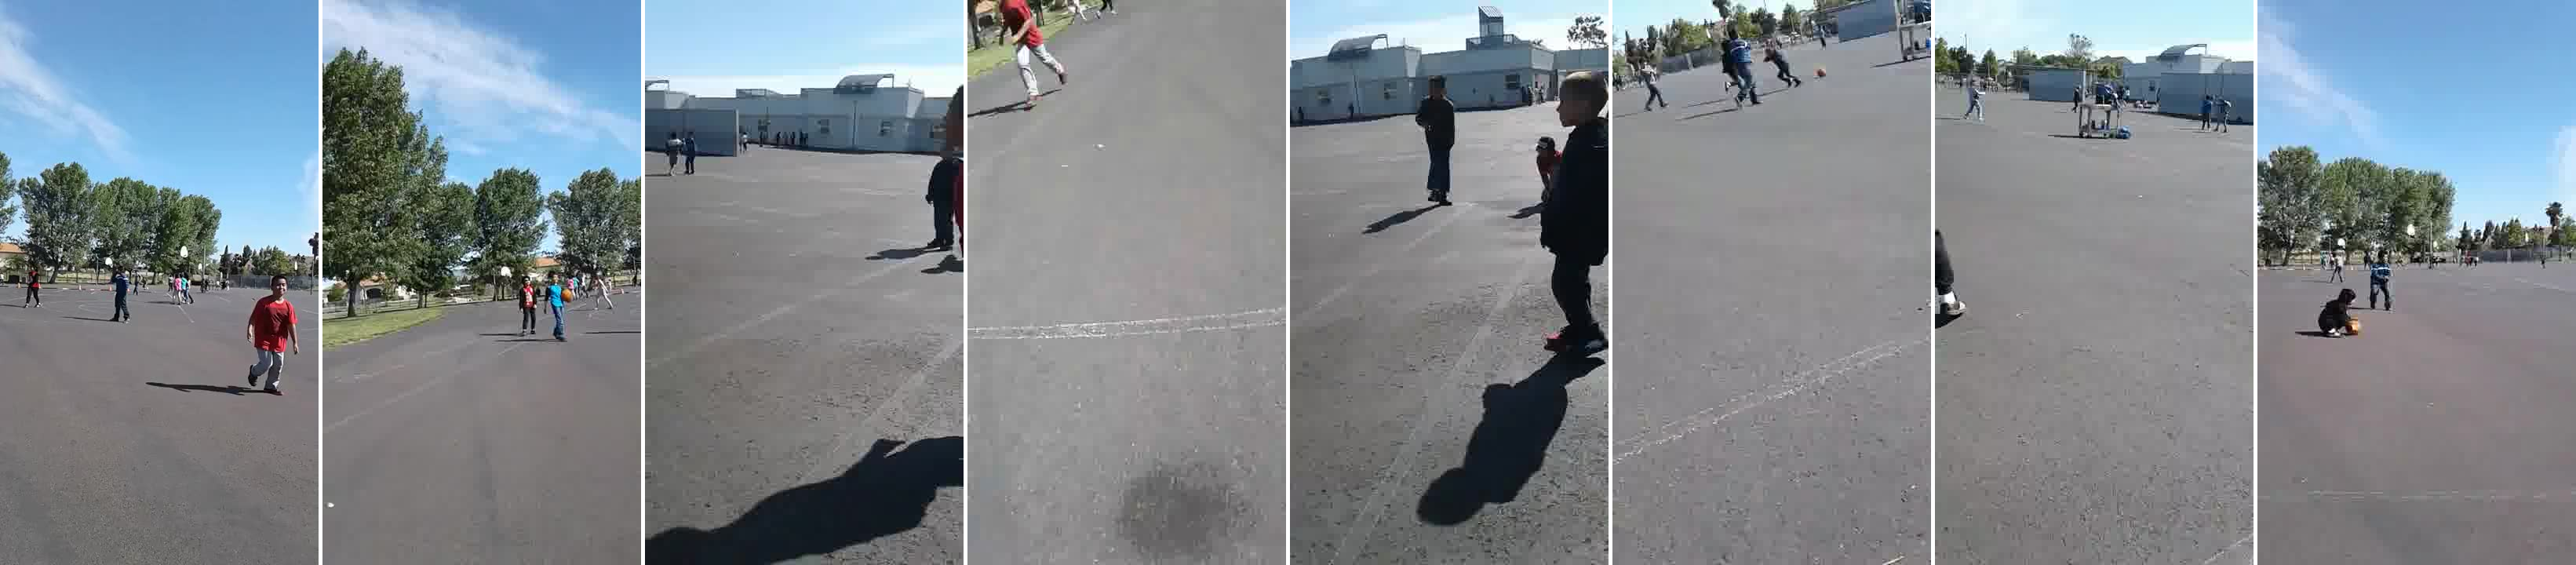

In [22]:
def read_frames(clip_id, n_frames=8):
    frame_dir = f"{video_dir}/{clip_id}"
    paths = natsorted(glob(f"{frame_dir}/*"))
    sf = 0
    ef = len(paths)
    n_frames = min(n_frames, ef - sf)
    indices = np.linspace(sf, ef, n_frames, endpoint=False, dtype=int)
    paths = np.array(paths)[indices]
    frames = [PIL.Image.open(f).convert("RGB") for f in paths]
    x = torch.stack(
        [torch.from_numpy(np.asarray(f)) for f in frames]
    )
    x = x.permute(0, 3, 1, 2)  # (T, C, H, W), torch.uint8
    return x


# frame_dir = "/datasets/ActivityNet/2020-version/activitynet_frames/v_ogQozSI5V8U"
# x = read_frames(frame_dir)
# x.shape

i = np.random.randint(len(df_anno))
row = df_anno.iloc[i]
frames = read_frames(row.clip_id)

display(Markdown(row.caption))
display(Markdown(f"{row.clustered_action}/{row.clustered_adverb}"))
su.visualize.concat_images_with_border(
    [PIL.Image.fromarray(x.numpy()) for x in frames.permute(0, 2, 3, 1)]
)

In [ ]:
def embed_video_action(clip_id, action, n_frames=16, verbose=False):

    PROMPT = "Video: <video>\n"\
             "Action: This video shows the action: <sent>\n"\
             "Look at the video carefully.\n"\
             "Summarize the action in the video in one word:"
    PROMPT = f"USER: {PROMPT} ASSISTANT: "

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare video
    # pixel_values = read_frames_decord(video_path, n_frames)
    pixel_values = read_frames(clip_id, n_frames).unsqueeze(0)
    pixel_values = transform_pixel_values(pixel_values)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', action)

        if verbose:
            print(input_prompt)
            print("-" * 120)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


i = 0
row = df_anno.iloc[i].to_dict()
zv = embed_video_action(
    row['clip_id'], row['clustered_action'], n_frames=8, verbose=True
)
zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float()
zv.shape